In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import lightkurve.periodogram as lkp
from astropy.table import vstack
from astropy.time import Time, TimeDelta
from astropy import units as u
from astropy.timeseries import LombScargle

from canislib.data import pload, psave, doublesort, remove_nans, remove_infs, sclip
from canislib.timeseriestools import dt64_to_days

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [13]:
def show_lk(times, dmags, dmagerrs, verbose=True):
    assert len(times) == len(dmags) == len(dmagerrs)
    if verbose:
        print(f'Raw light curve has {len(times)} values')
    """Remove nans, remove infs, and sigma clip"""
    times, dmags, dmagerrs = remove_nans([times, dmags, dmagerrs], verbose=verbose)
    times, dmags, dmagerrs = remove_infs([times, dmags, dmagerrs], verbose=verbose)
    sclipmask = sclip(dmags, sigma=3, verbose=verbose).mask
    times = times[~sclipmask]
    dmags = dmags[~sclipmask]
    dmagerrs = dmagerrs[~sclipmask]
    """LombScargle periodogram"""
    frequency, power = LombScargle(dt64_to_days(times), dmags, dy=dmagerrs).autopower()
    plt.figure()
    plt.plot(1/frequency, power)
    plt.xscale('log')
    plt.xlim(1, 300)
    plt.show()

In [3]:
def display(times, dmags, dmagerrs, title=None, ax1=None, ax2=None, cmd='1234',
    fout_png = None, fout_pickle=None):
    """Display light curve and LS periodogram. Optional data filtering."""
    def filter(lc, cmd='34'):
        for x in cmd:
            x = int(x)
            if x == 1:
                lc = lc.remove_nans('flux')
            if x == 2:
                lc = lc.remove_nans('flux_err')
            if x == 3:
                lc = lc.remove_outliers(sigma=3)
            if x == 4:
                print('HEY WE SHOULD NOT BE biNNING')
                lc = lc.bin(1 * u.day)
        return lc, cmd

    if ax1 is None and ax2 is None: 
        fig, axs = plt.subplots(ncols=1, nrows=3, figsize = (10,6.5*3/2+1))
        ax1 = axs[0]
        ax2 = axs[1]
        ax3 = axs[2]

    if title is not None:
        plt.suptitle(f'{title}')
        
    """Light curve"""
    lc = lk.LightCurve(time=Time(times), 
        flux = dmags, flux_err = dmagerrs)
    lc, cmd = filter(lc, cmd)
    lc.errorbar(ax=ax1, elinewidth=1, fmt='.', markersize=2)
    
    ax1.set_ylabel(r'$\Delta$ Mag')
    ax1.legend(fontsize=12) # title=cmd

    """Lomb Scargle Periodogram"""
    lc = lk.LightCurve(time=dt64_to_days(times), 
        flux = dmags, flux_err = dmagerrs)
    lc, cmd = filter(lc, cmd) #!!
    lsp = lkp.LombScarglePeriodogram.from_lightcurve(lc, maximum_frequency=1)
    lsp.plot(view='period', ax=ax2)
    ax2.set_xscale('log')
    #ax2.set_ylim(0, 0.25)
    ax2.set_xlim(1,1000)
    per = lsp.period_at_max_power
    pow = lsp.max_power
    ax2.axvline(per.value, color='r', label=f'Peak: {round(per.value, 3)} d\npower={round(pow.value, 3)}')
    ax2.set_title('LS Periodogram')
    ax2.axvline(0.5*per.value, color='rosybrown', label='harmonics')
    ax2.axvline(2*per.value, color='rosybrown')
    ax2.axvline(3*per.value, color='rosybrown')
    ax2.axvline(4*per.value, color='rosybrown')
    ax2.legend(fontsize=12)
    
    """Lomb Scargle Window"""
    lc = lk.LightCurve(time=dt64_to_days(times), 
        flux = np.ones(len(times))*1000)
    lsp = lkp.LombScarglePeriodogram.from_lightcurve(lc, maximum_frequency=1)
    lsp.plot(view='period', ax=ax3)
    ax3.set_xscale('log')
    ax3.set_title('LS Window function')
    #ax2.set_ylim(0, 0.25)
    ax3.set_xlim(1,1000)
    per = lsp.period_at_max_power
    pow = lsp.max_power
    plt.tight_layout()
    
    """Save figure"""
    if fout_png is not None:
        plt.savefig(fout_png, dpi=300)
    else:
        savefig(title=f'fig{cmd}', outdir='out/figures')
    if fout_pickle is not None:
        psave((fig, axs), fout_pickle)

def savefig(title='fig', outdir='.'):
    import os
    i = 0
    while os.path.exists(f'{outdir}/{title}{i}.png'):
        i += 1
    if i == 0:
        i = ""
    plt.savefig(f'{outdir}/{title}{i}.png', dpi=300)

def instrmag(aperture_sum):
    return -2.5*np.log10(aperture_sum)
    
def dmagerr(aperture_sum, aperture_sum_err):
    snr = aperture_sum / aperture_sum_err
    return np.abs(-2.5*np.log10(np.e) * 1/snr)

def dmag_diff(dmag_target, dmag_comps):
    return np.sqrt(dmag_target**2 + 1/len(dmag_comps)**2 * np.sum(np.square(dmag_comps)))


================== marana ==================


/var/folders/pl/xn351fl94vjg_9dw57yqmd6r0000gp/T/ipykernel_70268/377553501.py:86: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(aperture_sum)
/var/folders/pl/xn351fl94vjg_9dw57yqmd6r0000gp/T/ipykernel_70268/377553501.py:86: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(aperture_sum)
/var/folders/pl/xn351fl94vjg_9dw57yqmd6r0000gp/T/ipykernel_70268/377553501.py:89: RuntimeWarning: invalid value encountered in double_scalars
  snr = aperture_sum / aperture_sum_err
/var/folders/pl/xn351fl94vjg_9dw57yqmd6r0000gp/T/ipykernel_70268/1781575199.py:41: RuntimeWarning: invalid value encountered in double_scalars
  i = instrmag(flux[0]) - np.mean([instrmag(flux[i]) for i in range(1, N)])


Raw light curve has 2639 values
remove_nans removed 357 values
remove_infs removed 0 values
sigma_clip removed 63 values


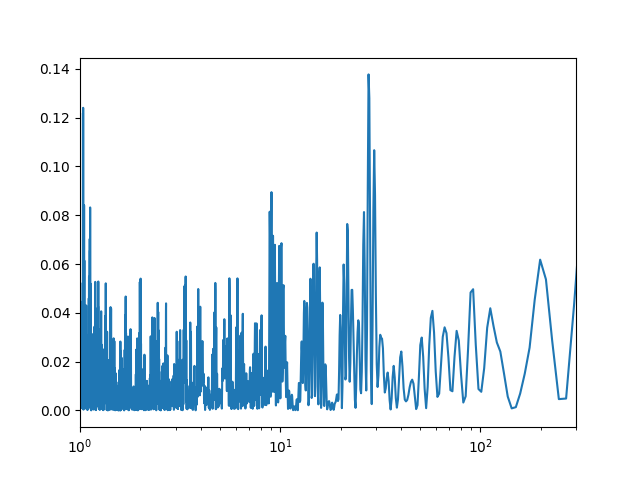


================== tek2k ==================
Raw light curve has 1146 values
remove_nans removed 34 values
remove_infs removed 0 values
sigma_clip removed 55 values


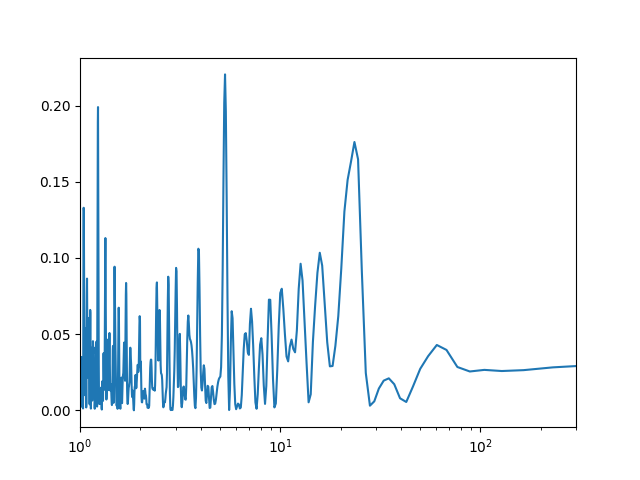


================== nd12 ==================


/var/folders/pl/xn351fl94vjg_9dw57yqmd6r0000gp/T/ipykernel_70268/377553501.py:86: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(aperture_sum)


Raw light curve has 825 values
remove_nans removed 188 values
remove_infs removed 0 values
sigma_clip removed 1 values


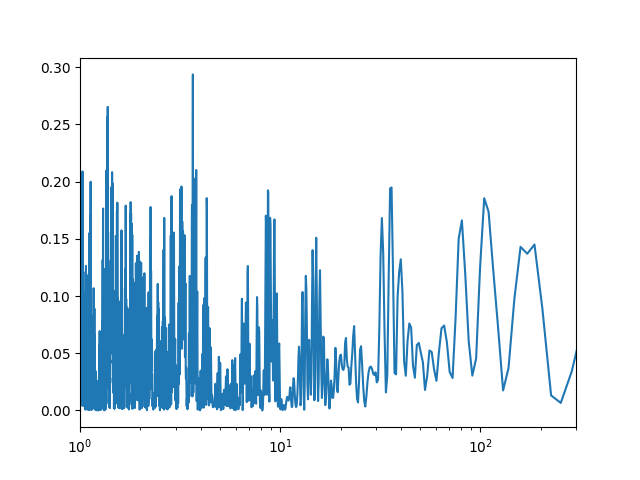


================== acam ==================


/var/folders/pl/xn351fl94vjg_9dw57yqmd6r0000gp/T/ipykernel_70268/377553501.py:86: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(aperture_sum)


Raw light curve has 1278 values
remove_nans removed 503 values
remove_infs removed 0 values
sigma_clip removed 20 values


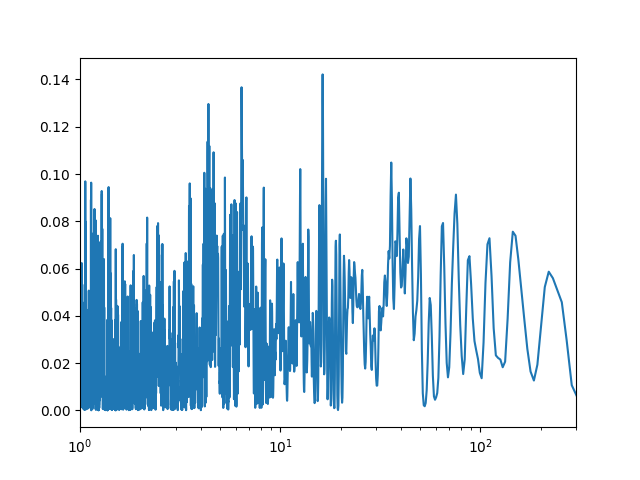

In [14]:
cams = ['marana', 'tek2k', 'nd12', 'acam']
outdir = 'out/figures'

"""photutils with errors"""
for cam in cams:
    print(f'\n================== {cam} ==================')
    results = pload(f'out/photometry/photutils_results_{cam}.p')
    seeings_dict = pload(f'out/seeings/seeings_{cam}.p')
    times = seeings_dict['times']
    files = seeings_dict['files']
    seeings = seeings_dict['seeings']

   # plt.close('all')

    """Instrumental"""
    # dmags = []
    # dmagerrs = []
    # for phot_table in results:
    #     if isinstance(phot_table, float):
    #         dmags.append(np.nan)
    #         dmagerrs.append(np.nan)
    #     else:
    #         flux = phot_table['aperture_sum']
    #         fluxerrs = phot_table['aperture_sum_err']
    #         dmags.append(instrmag(flux[0]))
    #         dmagerrs.append(dmagerr(flux[0], fluxerrs[0]))

    # display(times, dmags, dmagerrs, 'Instrumental')

    """Differential"""
    dmags = []
    dmagerrs = []
    for phot_table in results:
        if isinstance(phot_table, float):
            dmags.append(np.nan)
            dmagerrs.append(np.nan)
        else:
            flux = phot_table['aperture_sum']
            fluxerrs = phot_table['aperture_sum_err']
            N = len(flux)
            i = instrmag(flux[0]) - np.mean([instrmag(flux[i]) for i in range(1, N)])
            j = dmag_diff(dmagerr(flux[0], fluxerrs[0]), [dmagerr(flux[i], fluxerrs[i]) for i in range(1, N)])

            dmags.append(i)
            dmagerrs.append(j)
            
    show_lk(times, dmags, dmagerrs)
    # psave([times, dmags, dmagerrs], f'out/photometry/lightcurve_{cam}.p')
    # display(times, dmags, dmagerrs, f'{cam} Differential', cmd='123', fout_png=f'{outdir}/{cam}.png',
    #   fout_pickle=f'{outdir}/{cam}.pickle')
    #     # plt.figure()
    #     # from astropy.timeseries import LombScargle
    #     # frequency, power = LombScargle(dt64_to_days(times), np.ones(len(times))*10).autopower(maximum_frequency=1, minimum_frequency=1/300)

    # """Comp stars"""
    # N = len(results[0])
    # for i in range(1, N):
    #     dmags = []
    #     dmagerrs = []
    #     for phot_table in results:
    #         if isinstance(phot_table, float):
    #             dmags.append(np.nan)
    #             dmagerrs.append(np.nan)
    #         else:
    #             flux = phot_table['aperture_sum']
    #             fluxerrs = phot_table['aperture_sum_err']
    #             N = len(flux)
    #             dmags.append(instrmag(flux[i]) - np.nanmean([instrmag(flux[i]) for i in range(1, i)]+[instrmag(flux[i]) for i in range(i+1, N)]))
    #             dmagerrs.append(dmag_diff(dmagerr(flux[i], fluxerrs[i]), [dmagerr(flux[i], fluxerrs[i]) for i in range(1, i)] + [dmagerr(flux[i], fluxerrs[i]) for i in range(i+1, N)]))

    #     display(times, dmags, dmagerrs, f'{cam} Comp #{i} Differential', cmd='123', fout_png=f'{outdir}/{cam}_comp{i}.png',
    #   fout_pickle=f'{outdir}/{cam}_comp{i}.pickle')
    # print()

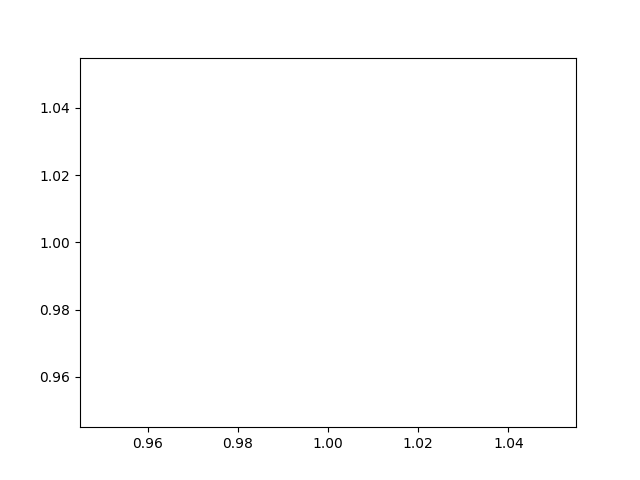

In [4]:
plt.figure()
plt.plot(1,1)
plt.show()

In [16]:
results = pload(f'out/photometry/photutils_results_marana.p')
np.sum([np.sum(np.isnan(res['aperture_sum'])) for res in results])

In [32]:
np.sum(np.isnan(dmagerrs))-np.sum(np.isnan(dmags))

391

In [ ]:
def list_string(strn):
    level=[]
    def permute(prefix, suffix):
      level.append(prefix)
      if len(suffix)==0:
        return
      for i in range(len(suffix)):
        permute(prefix + suffix[i], suffix[:i]+suffix[i+1:])
    permute("",strn)
    return level

In [ ]:
from canislib.data import triplesort
times_t = []
dmags_t = []
dmagerrs_t = []
for cam in ['marana', 'nd12', 'tek2k']:
    times, dmags, dmagerrs = pload(f'out/photometry/lightcurve_{cam}.p')
    times_t += times # list not numpy array
    dmags_t += dmags
    dmagerrs_t += dmagerrs
times_t, dmags_t, dmagerrs_t = triplesort(times_t, dmags_t, dmagerrs_t)

for cmd in ['123']:
    display(times_t, dmags_t, dmagerrs_t, f'ALL Differential', cmd=cmd)
# need to intercalibrate light curves

In [ ]:
plt.figure()
plt.scatter(dmags, dmagerrs)
plt.title('mags vs errors')

In [ ]:
len(pload('out/seeings/seeings_marana.p')['files'])

In [ ]:
Time(times[0]) + TimeDelta(1, format='jd')

In [ ]:
"""cntrds with errors"""
name = 'acam'
cntrds = pload(f'cntrds_{name}.p')
seeings_dict = pload(f'seeings_{name}.p')
times = seeings_dict['times']

plt.close('all')


dmags = cntrds.sel(param='mag', star=0).data
dmagerrs = cntrds.sel(param='sigmamag', star=0).data
display(times, dmags, dmagerrs, 'Instrumental')

dmags = cntrds.sel(param='mag', star=0).data - np.array([np.mean(x) for x in cntrds.sel(param='mag')[:, 1:].data])
dmagerrs = [dmag_diff(cntrds.sel(param='sigmamag')[i][0].data, cntrds.sel(param='sigmamag')[i][1:]).data for i in range(len(cntrds))]
display(times, dmags, dmagerrs, 'Differential')

N = len(results[0])
for i in range(1, N):
    dmags = [cntrds.sel(param='mag')[j][i].data - np.mean(np.concatenate([cntrds.sel(param='mag')[j][1:i].data, cntrds.sel(param='mag')[j][i+1:].data])) for j in range(len(cntrds))]
    dmagerrs = [dmag_diff(cntrds.sel(param='sigmamag')[j][i].data, np.concatenate([cntrds.sel(param='sigmamag')[j][1:i].data, cntrds.sel(param='sigmamag')[j][i+1:].data])) for j in range(len(cntrds))]
    display(times, dmags, dmagerrs, f'Comp#{i}')

In [ ]:
np.array([np.mean(x) for x in cntrds.sel(param='mag')[:, 1:].data])

In [ ]:
"""photutils: no error bars"""
results = pload('results_tek2k_noerror.p')
seeings_dict = pload('seeings_tek2k.p')
times = seeings_dict['times']
files = seeings_dict['files']
seeings = seeings_dict['seeings']

plt.close('all')
lc_raw = lk.LightCurve(time=dt64_to_days(times), 
    flux=[-2.5 * np.log10(phot_table['aperture_sum'][0])  for phot_table in results])
lc_diff = lk.LightCurve(time=dt64_to_days(times), 
    flux=[-2.5 * np.log10(phot_table['aperture_sum'][0] / np.mean(phot_table['aperture_sum'][1:]))  for phot_table in results])

display(lc_raw, 'Instrumental')
display(lc_diff, 'Differential')

N = len(results[0])
for i in range(1, N):
    dmags = [-2.5 * np.log(phot_table['aperture_sum'][i]/np.mean(vstack([phot_table['aperture_sum'][1:i+1], phot_table['aperture_sum'][i+2:]])['aperture_sum'])) 
            for phot_table in results]
    lc_comp = lk.LightCurve(time=dt64_to_days(times), flux= dmags)
    display(lc_comp, f'Comp #{i}')


In [ ]:
from astropy.timeseries import LombScargle
from canislib.timeseriestools import remove_nans

t, y = remove_nans(dt64_to_days(times), 
        [-2.5 * np.log10(phot_table['aperture_sum'][0]) for phot_table in results])
plt.figure()
frequency, power = LombScargle(t,y).autopower()
plt.xscale('log')
plt.xlim(1, 100)
plt.plot(1/frequency, power)